In [1]:
import pandas as pd
import numpy as np
import jdatetime
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Masking, Flatten
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Masking, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, GRU, Dense
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer


from src import SRC_DIR

In [2]:
event_log = pd.read_excel(SRC_DIR / 'Dataset' / 'Fall Sales Order.xlsx')

In [3]:
event_log_str=event_log['زمان انجام'].str.replace('/', ' ').str.replace(':', ' ').str.split()
event_log_int = [[int(val) for val in row] for row in event_log_str]
gregorian_date=[jdatetime.datetime(event_log_int[item][0],event_log_int[item][1],event_log_int[item][2],event_log_int[item][3],event_log_int[item][4],event_log_int[item][5]).togregorian() for item in range(99973)]
gregorian_date=pd.to_datetime(gregorian_date)
event_log['timestamp']=gregorian_date

In [4]:
event_log.head()

,شماره پرونده,فعاليت,زمان انجام,نوع سند,ناحيه فروش,شرح ناحيه فروش,مشتري,گروه مشتري,شرح گروه مشتري,نام کاربري,ويزيتور,نام ويزيتور,وضعیت مرجوعی,سند حمل,کد موزع,نام موزع,نوع پرداخت,شرح نوع پرداخت,timestamp
0,100989739,سفارش فروش,1400/07/01 08:11:44,ZO20,202012,منطقه10,14021788,1,خرده فروشي,VARANEGAR,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 08:11:44
1,100989739,تاييد سرپرست,1400/07/01 11:38:51,ZO20,202012,منطقه10,14021788,1,خرده فروشي,A_KESHAVARZ,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 11:38:51
2,100989739,دستور تحويل,1400/07/01 12:48:12,ZLF3,202012,منطقه10,14021788,1,خرده فروشي,F_ASHNAGAR,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 12:48:12
3,100989739,سند حمل,1400/07/01 15:15:40,ZP01,202012,منطقه10,14021788,1,خرده فروشي,H_FALAH,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 15:15:40
4,100989739,دريافت تور,1400/07/03 06:59:57,ZP01,202012,منطقه10,14021788,1,خرده فروشي,H_FALAH,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-25 06:59:57


In [5]:
event_log = event_log.rename(columns = {   'شماره پرونده':'case_id',
                                               'فعاليت':'activity',
                                           'گروه مشتري':'customer_group',
                                        'وضعیت مرجوعی':'returned_status',
                                             'نوع سند' :'document_type',
                                            'ناحيه فروش':'Sales_area',
                                            'نام کاربري':'user_name',
                                              'ويزيتور':'visitor',
                                           'کد موزع'  :'distributor',
                                           'نوع پرداخت':'payment',
                                             'سند حمل':'shipping document'
                                         })

In [6]:
event_log

,case_id,activity,زمان انجام,document_type,Sales_area,شرح ناحيه فروش,مشتري,customer_group,شرح گروه مشتري,user_name,visitor,نام ويزيتور,returned_status,shipping document,distributor,نام موزع,payment,شرح نوع پرداخت,timestamp
0,100989739,سفارش فروش,1400/07/01 08:11:44,ZO20,202012,منطقه10,14021788,1,خرده فروشي,VARANEGAR,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 08:11:44
1,100989739,تاييد سرپرست,1400/07/01 11:38:51,ZO20,202012,منطقه10,14021788,1,خرده فروشي,A_KESHAVARZ,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 11:38:51
2,100989739,دستور تحويل,1400/07/01 12:48:12,ZLF3,202012,منطقه10,14021788,1,خرده فروشي,F_ASHNAGAR,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 12:48:12
3,100989739,سند حمل,1400/07/01 15:15:40,ZP01,202012,منطقه10,14021788,1,خرده فروشي,H_FALAH,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-23 15:15:40
4,100989739,دريافت تور,1400/07/03 06:59:57,ZP01,202012,منطقه10,14021788,1,خرده فروشي,H_FALAH,E5700979,فرزاد اصغر زاده,مرجوع نشده,142600,E5700198,احمد امین,PTCA,نقدي - تسويه تا راس مشمول نقد,2021-09-25 06:59:57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99968,101189084,سند حمل,1400/09/30 16:21:59,ZP01,202005,منطقه2,14020440,1,خرده فروشي,H_FALAH,E5701645,مهرداد لطفی علیداشی,مرجوع نشده,166751,E5700198,احمد امین,PT01,نقد / حواله / پوز - تسويه کامل آني,2021-12-21 16:21:59
99969,101189084,دريافت تور,1400/10/01 06:54:30,ZP01,202005,منطقه2,14020440,1,خرده فروشي,H_FALAH,E5701645,مهرداد لطفی علیداشی,مرجوع نشده,166751,E5700198,احمد امین,PT01,نقد / حواله / پوز - تسويه کامل آني,2021-12-22 06:54:30
99970,101189084,ارسال تور,1400/10/01 12:20:50,ZP01,202005,منطقه2,14020440,1,خرده فروشي,H_FALAH,E5701645,مهرداد لطفی علیداشی,مرجوع نشده,166751,E5700198,احمد امین,PT01,نقد / حواله / پوز - تسويه کامل آني,2021-12-22 12:20:50
99971,101189084,سند انبار,1400/10/01 13:43:54,WL,202005,منطقه2,14020440,1,خرده فروشي,R_MIRAZIMI,E5701645,مهرداد لطفی علیداشی,مرجوع نشده,166751,E5700198,احمد امین,PT01,نقد / حواله / پوز - تسويه کامل آني,2021-12-22 13:43:54


In [8]:
shipping_document_unique=event_log['shipping document'].unique()
shipping_document_unique.shape

(694,)

In [9]:
customer_unique=event_log['مشتري'].unique().shape
customer_unique

(4678,)

<div style="direction:rtl;line-height:300%;">
	<font face="XB Nazanin" size=4 color=blue>
		<div align=right>
			<font face="B Nazanin" size=5>
				<p></p>
              ستون‌های تکراری از نظر اطلاعات مانند ستون‌هایی که شرح ستون دیگری هستند و یا مواردی که همزمان یک ستون نام و یک ستون کد به آن‌ها اختصاص داده شده است از دیتافریم حذف می‌گردد. همچنین ستون مشتری و سند حمل به دلیل مقادیر یکتای زیاد در نظر گرفته نمی‌شوند. 

In [10]:
event_log_new=event_log[['case_id','activity','timestamp','document_type','Sales_area','customer_group','user_name','returned_status','distributor','payment']]

In [14]:
event_log_new

,case_id,activity,timestamp,document_type,Sales_area,customer_group,user_name,returned_status,distributor,payment
0,100989739,سفارش فروش,2021-09-23 08:11:44,ZO20,202012,1,VARANEGAR,مرجوع نشده,E5700198,PTCA
1,100989739,تاييد سرپرست,2021-09-23 11:38:51,ZO20,202012,1,A_KESHAVARZ,مرجوع نشده,E5700198,PTCA
2,100989739,دستور تحويل,2021-09-23 12:48:12,ZLF3,202012,1,F_ASHNAGAR,مرجوع نشده,E5700198,PTCA
3,100989739,سند حمل,2021-09-23 15:15:40,ZP01,202012,1,H_FALAH,مرجوع نشده,E5700198,PTCA
4,100989739,دريافت تور,2021-09-25 06:59:57,ZP01,202012,1,H_FALAH,مرجوع نشده,E5700198,PTCA
...,...,...,...,...,...,...,...,...,...,...
99968,101189084,سند حمل,2021-12-21 16:21:59,ZP01,202005,1,H_FALAH,مرجوع نشده,E5700198,PT01
99969,101189084,دريافت تور,2021-12-22 06:54:30,ZP01,202005,1,H_FALAH,مرجوع نشده,E5700198,PT01
99970,101189084,ارسال تور,2021-12-22 12:20:50,ZP01,202005,1,H_FALAH,مرجوع نشده,E5700198,PT01
99971,101189084,سند انبار,2021-12-22 13:43:54,WL,202005,1,R_MIRAZIMI,مرجوع نشده,E5700198,PT01


In [11]:
# Group the DataFrame by column case_id
grouped = event_log.groupby('case_id')

# Convert the grouped DataFrame to a numpy array
case_activities = np.array([grouped.get_group(x)['activity'].values for x in grouped.groups], dtype=object)
case_document_type = np.array([grouped.get_group(x)['document_type'].values for x in grouped.groups], dtype=object)
case_Sales_area = np.array([grouped.get_group(x)['Sales_area'].values for x in grouped.groups], dtype=object)
case_customer_group = np.array([grouped.get_group(x)['customer_group'].values for x in grouped.groups], dtype=object)
case_user_name = np.array([grouped.get_group(x)['user_name'].values for x in grouped.groups], dtype=object)
case_returned_status = np.array([grouped.get_group(x)['returned_status'].values for x in grouped.groups], dtype=object)
case_distributor = np.array([grouped.get_group(x)['distributor'].values for x in grouped.groups], dtype=object)
case_payment = np.array([grouped.get_group(x)['payment'].values for x in grouped.groups], dtype=object)

# Create a list of all unique activities and other features
activities_list = sorted(event_log.activity.unique())
document_type_list = sorted(event_log['document_type'].unique())
Sales_area_list = sorted(event_log['Sales_area'].unique())
customer_group_list = sorted(event_log['customer_group'].unique())
user_name_list = sorted(event_log['user_name'].unique())
returned_status_list = sorted(event_log['returned_status'].unique())
distributor_list = sorted(event_log['distributor'].unique())
payment_list = sorted(event_log['payment'].unique())

# Create a dictionary that maps each features to a unique array
activity_index = {activity: [int(ind == index) for ind in range(len(activities_list))]
                  for index, activity in enumerate(activities_list)}

document_type_index = {document_type: [int(ind == index) for ind in range(len(document_type_list))]
                 for index, document_type in enumerate(document_type_list)}

Sales_area_index = {Sales_area: [int(ind == index) for ind in range(len(Sales_area_list))]
            for index, Sales_area in enumerate(Sales_area_list)}

customer_group_index = {customer_group: [int(ind == index) for ind in range(len(customer_group_list))]
                for index, customer_group in enumerate(customer_group_list)}

user_name_index = {user_name: [int(ind == index) for ind in range(len(user_name_list))]
                for index, user_name in enumerate(user_name_list)}

returned_status_index = {returned_status: [int(ind == index) for ind in range(len(returned_status_list))]
                for index, returned_status in enumerate(returned_status_list)}


distributor_index = {distributor: [int(ind == index) for ind in range(len(distributor_list))]
                for index, distributor in enumerate(distributor_list)}

payment_index = {payment: [int(ind == index) for ind in range(len(payment_list))]
                for index, payment in enumerate(payment_list)}


# Convert each activity and resourse in the event log to its corresponding array
embedded_activity = [[activity_index[activity] for activity in case] for case in case_activities]
embedded_document_type = [[document_type_index[document_type] for document_type in case] for case in case_document_type]
embedded_Sales_area = [[Sales_area_index[Sales_area] for Sales_area in case] for case in case_Sales_area]
embedded_customer_group= [[customer_group_index[customer_group] for customer_group in case] for case in case_customer_group]
embedded_user_name = [[user_name_index[user_name] for user_name in case] for case in case_user_name]
embedded_returned_status = [[returned_status_index[returned_status] for returned_status in case] for case in case_returned_status]
embedded_distributor = [[distributor_index[distributor] for distributor in case] for case in case_distributor]
embedded_payment = [[payment_index[payment] for payment in case] for case in case_payment]


# Concatenate the two lists and indexed event log
embedded_eventlog = []
for case in zip(embedded_activity, embedded_document_type, embedded_Sales_area, embedded_customer_group,embedded_user_name,embedded_returned_status,embedded_distributor,embedded_payment):
    case_list = []
    for activity, document_type, Sales_area, customer_group,user_name,returned_status,distributor,payment in zip(case[0], case[1], case[2], case[3],case[4],case[5],case[6],case[7]):
        case_list.append(activity + document_type + Sales_area +customer_group+user_name+returned_status+distributor+payment)
    embedded_eventlog.append(case_list)

In [12]:
event_log.sort_values(["case_id", "case_id"], inplace=True)
event_log.reset_index(drop=True, inplace=True)

event_log['next_activity'] = event_log.activity.shift(-1)
event_log.loc[event_log.case_id != event_log.case_id.shift(-1), 'next_activity'] = 'End'

case_next_activities = np.array([grouped.get_group(x)['next_activity'].values for x in grouped.groups], dtype=object)
next_activity_list = sorted(list(set([nextactivity for case in case_next_activities for nextactivity in case])))
next_activity_index = {nextactivity: [int(ind == index) for ind in range(len(next_activity_list))] for index, nextactivity in enumerate(next_activity_list)}
embedded_next_activity = [[next_activity_index[activity] for activity in case] for case in case_next_activities]

In [13]:
X_dataset = []
Y_dataset = []

for case, target in zip(embedded_eventlog, embedded_next_activity):
    for i in range(len(case)):
        X_dataset.append(case[:i+1])
        Y_dataset.append(target[i])

Y_dataset = np.array(Y_dataset)

# Pad the indexed event_log to a fixed length
max_case_length = max([len(case) for case in embedded_eventlog])
X_dataset = pad_sequences(X_dataset, maxlen=max_case_length)

In [16]:
type(X_dataset)

numpy.ndarray

In [23]:
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=X_dataset.shape[1:]))
model.add(GRU(units=4, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(GRU(units=4, dropout=0.1, recurrent_dropout=0.2))
model.add(Dense(units=Y_dataset.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 10
batch_size=500

# Fit the model to the training data
history = model.fit(X_dataset, Y_dataset, epochs=epochs, batch_size=batch_size, validation_split=0.3)



Epoch 1/10
140/140 [==============================] - 36s 80ms/step - loss: 1.9519 - accuracy: 0.2369 - val_loss: 1.7217 - val_accuracy: 0.3411
Epoch 2/10
140/140 [==============================] - 8s 59ms/step - loss: 1.5377 - accuracy: 0.3813 - val_loss: 1.3522 - val_accuracy: 0.5041
Epoch 3/10
140/140 [==============================] - 8s 56ms/step - loss: 1.2519 - accuracy: 0.6387 - val_loss: 1.0856 - val_accuracy: 0.8740
Epoch 4/10
140/140 [==============================] - 6s 46ms/step - loss: 1.0038 - accuracy: 0.7875 - val_loss: 0.8582 - val_accuracy: 0.8740
Epoch 5/10
140/140 [==============================] - 8s 59ms/step - loss: 0.8231 - accuracy: 0.8383 - val_loss: 0.7020 - val_accuracy: 0.8740
Epoch 6/10
140/140 [==============================] - 7s 49ms/step - loss: 0.6900 - accuracy: 0.8556 - val_loss: 0.5992 - val_accuracy: 0.8740
Epoch 7/10
140/140 [==============================] - 8s 56ms/step - loss: 0.6004 - accuracy: 0.8780 - val_loss: 0.5244 - val_accuracy: 0.920

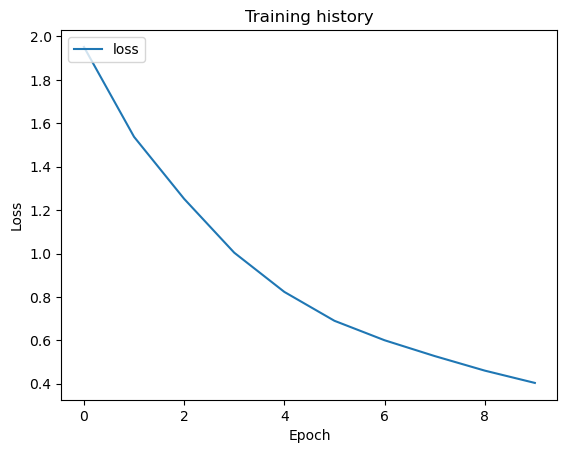

In [24]:
# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

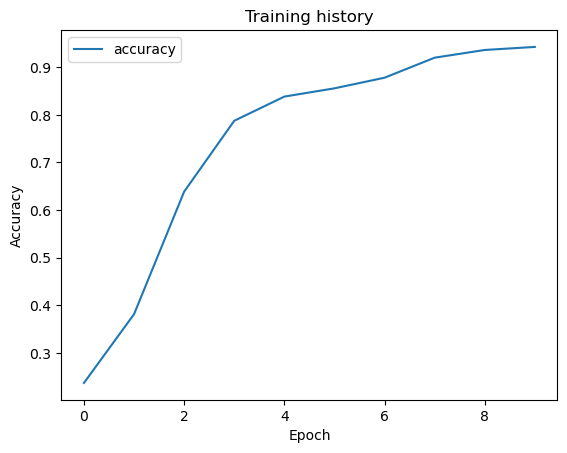

In [25]:
# Plot the training accuracy
plt.plot(history.history['accuracy'])
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy'], loc='upper left')
plt.show()